In [2]:
import os
import numpy as np # type: ignore
import tensorflow as tf # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random
from PIL import Image, UnidentifiedImageError # type: ignore
from sklearn.metrics import r2_score # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore

In [3]:
csv_path = r"D:\Database & Datasets\myntradataset\styles.csv"
images_folder = r"D:\Database & Datasets\myntradataset\images/"

# Load CSV
df = pd.read_csv(csv_path, on_bad_lines='skip')

# Add image paths to DataFrame
df['image_path'] = df['id'].astype(str).apply(lambda x: os.path.join(images_folder, f"{x}.jpg"))

# Function to load images from paths
def load_images_from_paths(image_paths):
    images = []
    valid_paths = []
    for path in image_paths:
        if os.path.exists(path):
            img = Image.open(path)
            img_array = np.array(img)
            images.append(img_array)
            valid_paths.append(path)
    return images, valid_paths

# Load images and filter valid paths
images, valid_paths = load_images_from_paths(df['image_path'])

# Filter DataFrame to keep only valid images
df = df[df['image_path'].isin(valid_paths)].reset_index(drop=True)

# Create DataFrame with image data
image_df = pd.DataFrame({'image_data': images})

# Combine image data with original DataFrame
data = df.copy()
data['image_data'] = image_df['image_data']

print(f"Remaining valid images: {len(data)}")

print(data.columns)

Remaining valid images: 44419
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'image_path', 'image_data'],
      dtype='object')


In [4]:
label_counts = df['masterCategory'].value_counts().to_dict()

print(label_counts)

{'Apparel': 21392, 'Accessories': 11274, 'Footwear': 9219, 'Personal Care': 2403, 'Free Items': 105, 'Sporting Goods': 25, 'Home': 1}


In [5]:
# Set the target column
data['label'] = data['masterCategory'].astype(str)

# Split the data into training, testing, and validation sets
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=42)

In [6]:
# Define the categories to drop
categories_to_drop = ['Personal Care', 'Free Items', 'Sporting Goods', 'Home']

# Drop the specified categories from the train dataset
df_train_filtered = df_train[~df_train['masterCategory'].isin(categories_to_drop)]

# Drop the specified categories from the test dataset
df_test_filtered = df_test[~df_test['masterCategory'].isin(categories_to_drop)]

# Drop the specified categories from the validation dataset
df_val_filtered = df_val[~df_val['masterCategory'].isin(categories_to_drop)]

# Verify the categories have been dropped from the train dataset
label_counts_train_filtered = df_train_filtered['masterCategory'].value_counts().to_dict()
print("Train dataset label counts after filtering:", label_counts_train_filtered)

# Verify the categories have been dropped from the test dataset
label_counts_test_filtered = df_test_filtered['masterCategory'].value_counts().to_dict()
print("Test dataset label counts after filtering:", label_counts_test_filtered)

# Verify the categories have been dropped from the validation dataset
label_counts_val_filtered = df_val_filtered['masterCategory'].value_counts().to_dict()
print("Validation dataset label counts after filtering:", label_counts_val_filtered)


datagen = ImageDataGenerator(rescale=1.0/255.0)

Train dataset label counts after filtering: {'Apparel': 17114, 'Accessories': 9011, 'Footwear': 7392}
Test dataset label counts after filtering: {'Apparel': 2180, 'Accessories': 1131, 'Footwear': 894}
Validation dataset label counts after filtering: {'Apparel': 2098, 'Accessories': 1132, 'Footwear': 933}


In [ ]:
df_train_sampled = df_train_filtered.sample(frac=0.1, random_state=42)  # Use 10% of the training data
df_val_sampled = df_val_filtered.sample(frac=0.8, random_state=42)  # Use 80% of the validation data

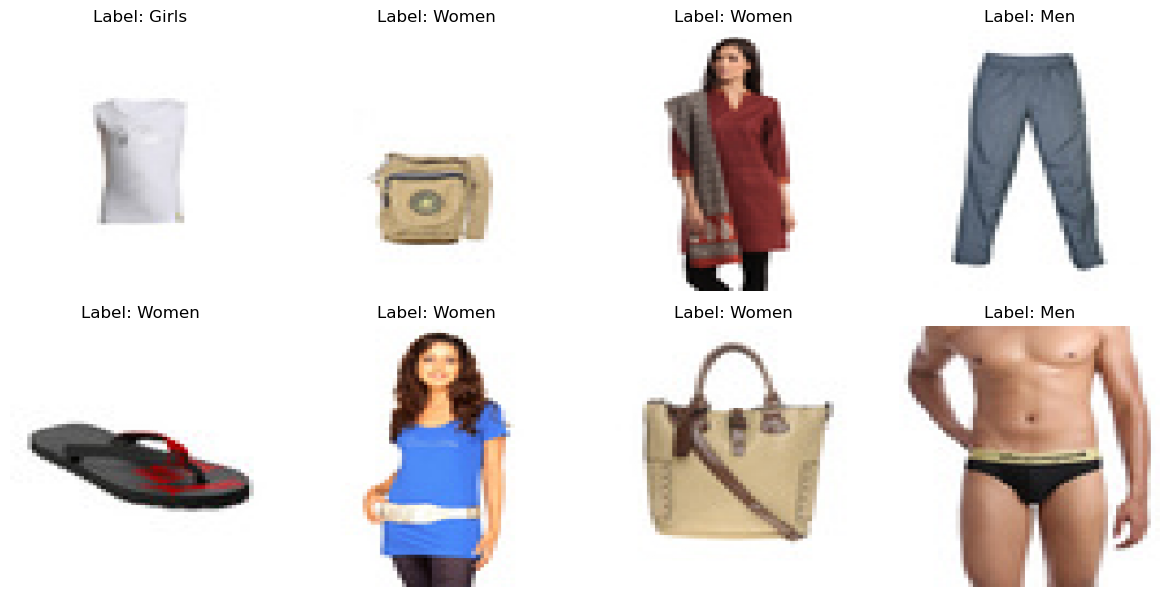

In [8]:
from tensorflow.keras.preprocessing import image #type: ignore

# Plot 8 random images from the train dataset
random_indices_train = random.sample(range(len(df_train)), 8)
image_paths_train = df_train['image_path'].iloc[random_indices_train]
labels_train = df_train['gender'].iloc[random_indices_train]

plt.figure(figsize=(12, 12))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    img = image.load_img(image_paths_train.iloc[i], target_size=(226, 226))
    img_array = image.img_to_array(img) / 255.0
    plt.imshow(img_array)
    plt.title(f"Label: {labels_train.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

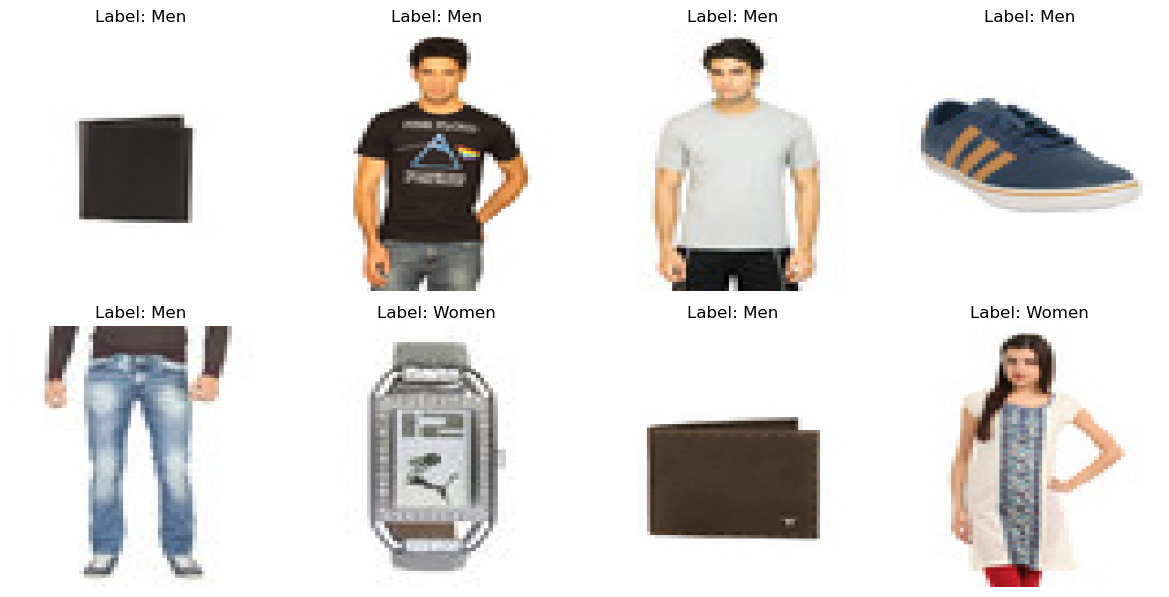

In [9]:
# Plot 8 random images from the test dataset
random_indices_test = random.sample(range(len(df_test)), 8)
image_paths_test = df_test['image_path'].iloc[random_indices_test]
labels_test = df_test['gender'].iloc[random_indices_test]

plt.figure(figsize=(12, 12))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    img = image.load_img(image_paths_test.iloc[i], target_size=(226, 226))
    img_array = image.img_to_array(img) / 255.0
    plt.imshow(img_array)
    plt.title(f"Label: {labels_test.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\npars\AppData\Local\Temp\ipykernel_25072\3660906763.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=usage_counts.values, y=usage_counts.index, palette="viridis", orient='h')


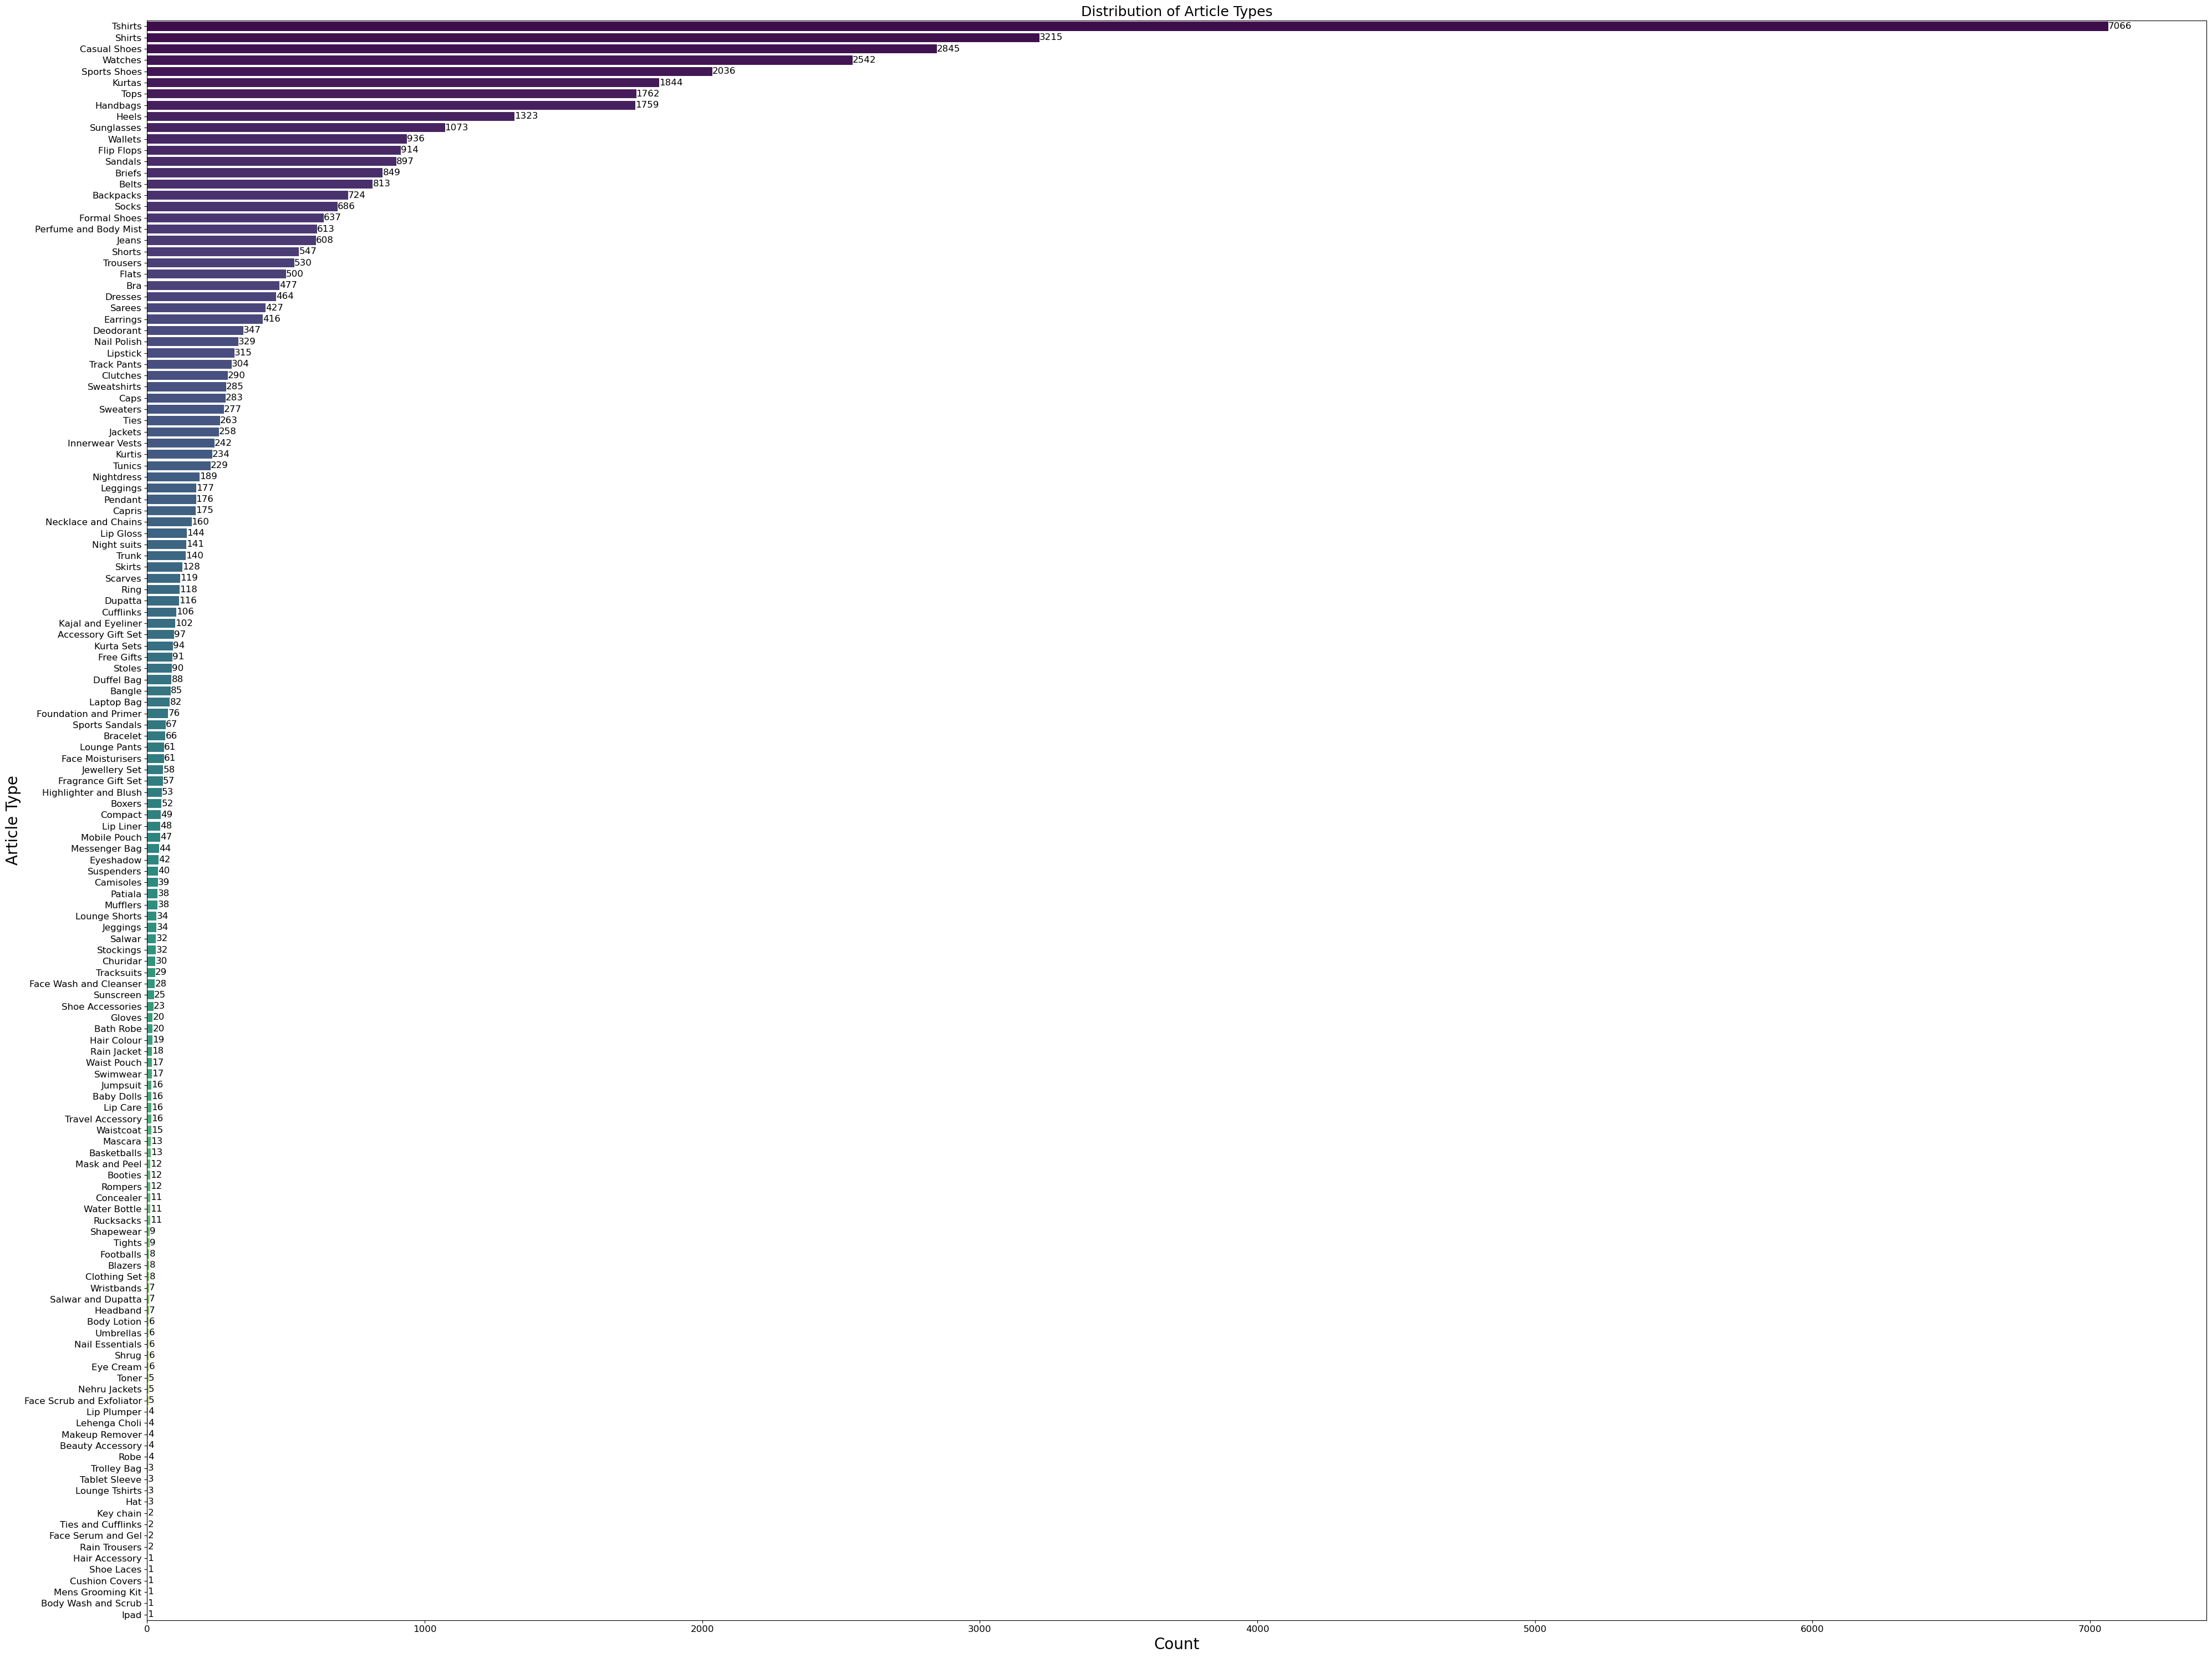

In [10]:
import matplotlib.pyplot as plt #type: ignore
import seaborn as sns #type: ignore

# Count the occurrences of each articleType
usage_counts = df['articleType'].value_counts()

# Plot the bar chart
plt.figure(figsize=(40, 30))
sns.barplot(x=usage_counts.values, y=usage_counts.index, palette="viridis", orient='h')

# Add labels and title
plt.xlabel("Count", fontsize=20)
plt.ylabel("Article Type", fontsize=20)
plt.title("Distribution of Article Types", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels to each bar
for index, value in enumerate(usage_counts.values):
    plt.text(value, index, str(value), color='black', ha="left", va="center", fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
#3
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_filtered,
    x_col='image_path',
    y_col='masterCategory',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical'  ,
    shuffle=True
)

# Create a new data generator for the sampled data
train_generator_sampled = datagen.flow_from_dataframe(
    dataframe=df_train_sampled,
    x_col='image_path',
    y_col='masterCategory',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df_val_filtered,
    x_col='image_path',
    y_col='masterCategory',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  
)

val_generator_sampled = datagen.flow_from_dataframe(
    dataframe=df_val_sampled,
    x_col='image_path',
    y_col='masterCategory',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test_filtered,
    x_col='image_path',
    y_col='masterCategory',
    target_size=(226, 226),
    batch_size=32,
    class_mode='categorical'  
)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical", input_shape=(226, 226, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

Found 33517 validated image filenames belonging to 3 classes.
Found 3352 validated image filenames belonging to 3 classes.
Found 4163 validated image filenames belonging to 3 classes.
Found 3330 validated image filenames belonging to 3 classes.
Found 4205 validated image filenames belonging to 3 classes.


c:\Users\npars\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#5
from tensorflow.keras.layers import LeakyReLU # type: ignore
 # type: ignore
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(64, (3, 3),input_shape=(226, 226, 3)),
    tf.keras.layers.BatchNormalization(),
    LeakyReLU(alpha=0.01),
    
    #1
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    #2
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    
    #3
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    #4
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    
    #5
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    
    #6
    tf.keras.layers.Conv2D(256, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    
    #7
    tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    
    #8
     tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.BatchNormalization(),  
    LeakyReLU(alpha=0.01),
    
    #9
    tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    LeakyReLU(alpha=0.01),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling2D(),
    
    #Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.5),
    
    #D1
    tf.keras.layers.Dense(256),
    LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.5),
    
    #D2
    tf.keras.layers.Dense(128),
    LeakyReLU(alpha=0.01),
    tf.keras.layers.Dropout(0.5),
    
    
    tf.keras.layers.Dense(3, activation='softmax')  
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


checkpoint_filepath = '/tmp/checkpoint.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

c:\Users\npars\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\npars\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
#6
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 226, 226, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 222, 222, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 109, 109, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 107, 107, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 107, 107, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 107, 107, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 51, 51, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 51, 51, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 49, 49, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 8,073,283 (30.80 MB)

 Trainable params: 8,067,907 (30.78 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [14]:
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True),
    model_checkpoint_callback,
]

In [15]:
history = model.fit(
    train_generator_sampled,
    epochs=10,
    validation_data=val_generator_sampled,
    callbacks=callbacks
)

Epoch 1/10


c:\Users\npars\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\npars\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


105/105 ━━━━━━━━━━━━━━━━━━━━ 824s 8s/step - accuracy: 0.4727 - loss: 1.2648 - val_accuracy: 0.5511 - val_loss: 1.0184
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 968s 9s/step - accuracy: 0.6055 - loss: 0.8775 - val_accuracy: 0.5108 - val_loss: 1.7304
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 836s 8s/step - accuracy: 0.6384 - loss: 0.7821 - val_accuracy: 0.3589 - val_loss: 1.1963


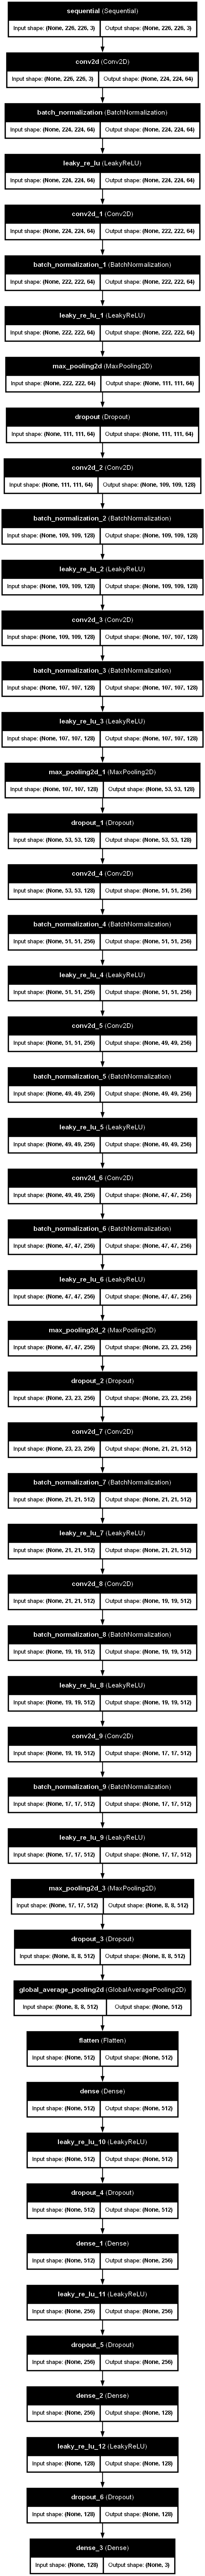

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

<Axes: >

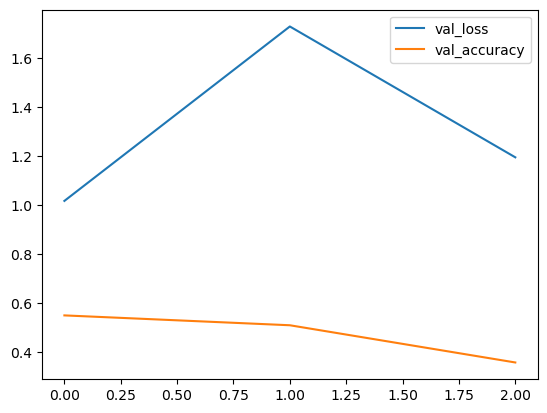

In [17]:
#8
metrics_df = pd.DataFrame(history.history)

metrics_df[["val_loss","val_accuracy"]].plot()

In [18]:
# Re-evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
model.save('Havij.h5')

c:\Users\npars\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.5689 - loss: 1.0232


Test Loss: 1.027069091796875, Test Accuracy: 0.5614744424819946


In [38]:
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model('Havij.h5')

# # Re-evaluate the model on the test set (optional)
# test_loss, test_acc = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step


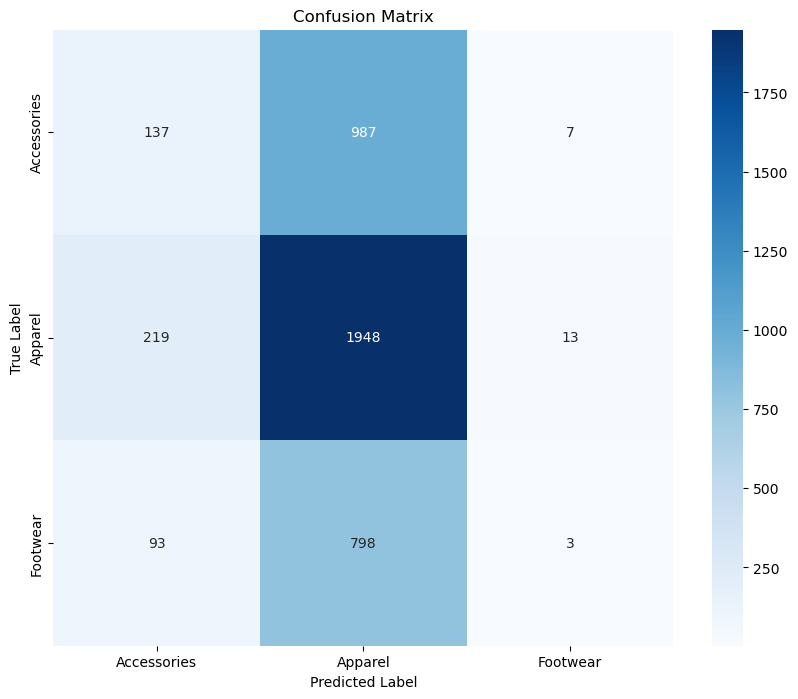

              precision    recall  f1-score   support

 Accessories       0.31      0.12      0.17      1131
     Apparel       0.52      0.89      0.66      2180
    Footwear       0.13      0.00      0.01       894

    accuracy                           0.50      4205
   macro avg       0.32      0.34      0.28      4205
weighted avg       0.38      0.50      0.39      4205



In [19]:
#10 conf + plot 
#11 classification rep + plot
import numpy as np # type: ignore
from sklearn.metrics import confusion_matrix, classification_report # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Make predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [22]:
from tensorflow.keras.models import Model # type: ignore
# Create a new model that outputs the features from the global average pooling layer
feature_extractor = Model(inputs=model.get_layer('sequential').input, outputs=model.get_layer('global_average_pooling2d').output)

# Extract features from the validation set
val_generator.reset()
features = feature_extractor.predict(val_generator)

# Get the true labels
true_labels = val_generator.classes

# Create a DataFrame to store the features and labels
features_df = pd.DataFrame(features)
features_df['label'] = true_labels

# Save the features to a CSV file
features_df.to_csv('validation_features.csv', index=False)

# Print the shape of the extracted features
print(f"Extracted features shape: {features.shape}")

c:\Users\npars\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step
Extracted features shape: (4163, 512)


Indices of similar images: [4028 3366 3154 1264 2326]


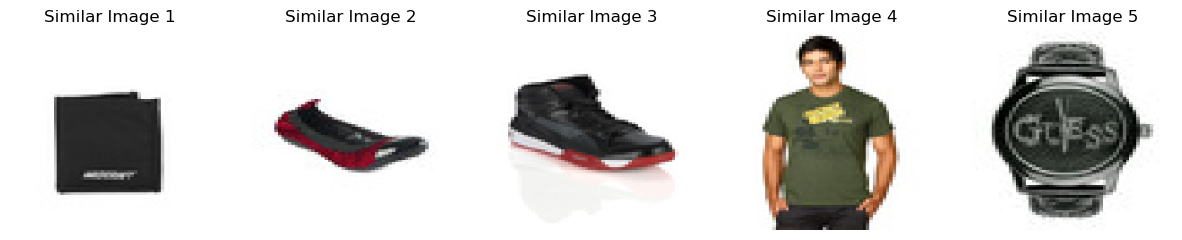

In [31]:
from sklearn.metrics.pairwise import cosine_similarity # type: ignore

cosine_sim = cosine_similarity(features)

def get_similar_images(image_index, top_n=5):
    similar_indices = np.argsort(-cosine_sim[image_index])[:top_n]
    return similar_indices

def display_similar_images(image_index, similar_images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, idx in enumerate(similar_images[:num_images]):
        img_path = val_generator.filenames[idx]
        img = image.load_img(img_path, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Similar Image {i+1}")
    plt.show()

image_index = random.randint(0,len(features)-1)
similar_images = get_similar_images(image_index)

print(f"Indices of similar images: {similar_images}")

display_similar_images(image_index, similar_images)

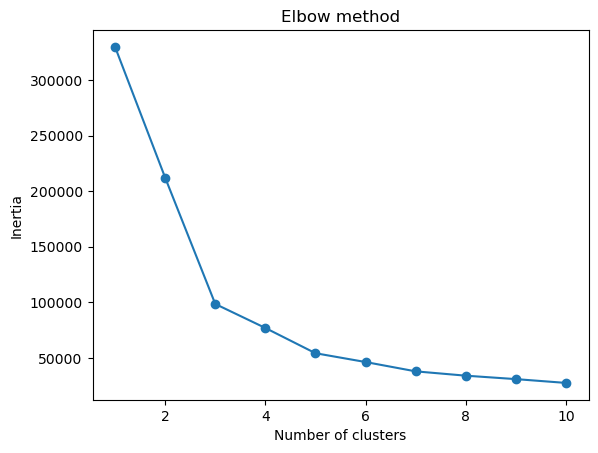

In [36]:
from sklearn.cluster import KMeans # type: ignore

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Cluster centers: [[ 6.5852219e-01  9.6171290e-01  7.1593374e-01 ...  2.8673798e-01
   9.6915877e-01 -2.4889726e-03]
 [ 4.5386314e-01  4.7257665e-01  3.0214262e-01 ...  4.8316735e-01
   3.0922425e-01  3.5094038e-02]
 [ 1.1526498e+00  2.4958460e+00  1.0262361e+00 ...  5.9318882e-01
   1.7615033e+00 -1.0632569e-02]
 [ 5.9256762e-01  7.4854791e-01  1.3277987e-01 ...  8.9691228e-01
   1.6409761e-01  6.7752879e-03]
 [ 3.2069212e-01  3.4545526e-01  5.3412962e-01 ...  1.5774715e-01
   5.3238219e-01  4.0644191e-02]]


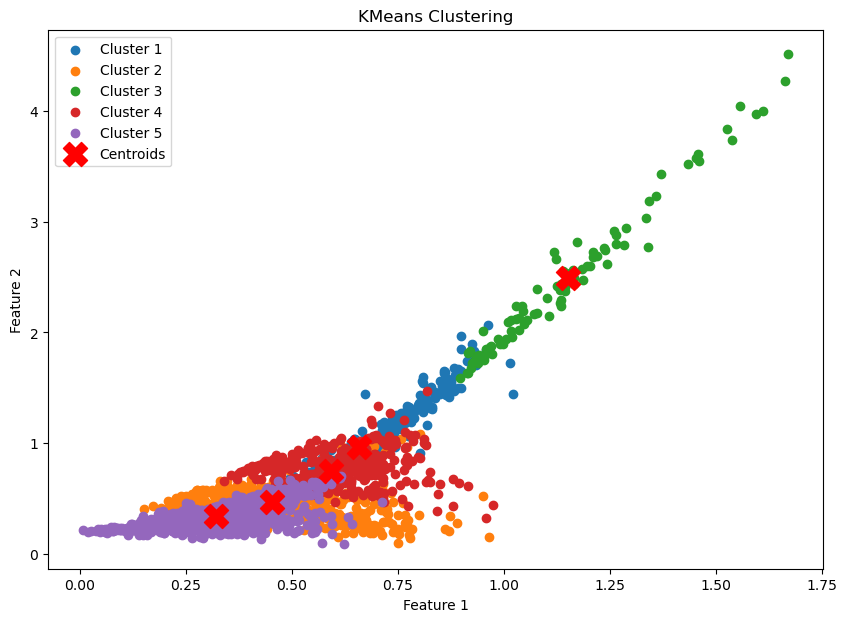

In [37]:
# Fit KMeans with a specified number of clusters
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a DataFrame with features and cluster labels
features_df = pd.DataFrame(features)
features_df['cluster'] = labels

# Save the DataFrame to a CSV file
features_df.to_csv('clustered_features.csv', index=False)

print(f"Cluster centers: {kmeans.cluster_centers_}")

# Plot the clusters
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    cluster_points = features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroids', marker='X')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:
# import numpy as np
# import random
# from sklearn.metrics.pairwise import cosine_similarity # type: ignore
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing import image

# # Compute cosine similarity
# cosine_sim = cosine_similarity(features)

# def get_similar_images(image_index, top_n=5):
#     similar_indices = np.argsort(-cosine_sim[image_index])[:top_n]
#     return similar_indices

# def display_similar_images(image_index, similar_images, num_images=5):
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
#     for i, idx in enumerate(similar_images[:num_images]):
#         img_path = val_generator.filenames[idx]
#         img = image.load_img(img_path, target_size=(224, 224))
#         axes[i].imshow(img)
#         axes[i].axis('off')
#         axes[i].set_title(f"Similar Image {i+1}")
#     plt.show()

# def recommend_clothes_set(num_items=3):
#     recommended_indices = random.sample(range(len(features)), num_items)
#     fig, axes = plt.subplots(1, num_items, figsize=(15, 15))
#     for i, idx in enumerate(recommended_indices):
#         img_path = val_generator.filenames[idx]
#         img = image.load_img(img_path, target_size=(224, 224))
#         axes[i].imshow(img)
#         axes[i].axis('off')
#         axes[i].set_title(f"Recommended Item {i+1}")
#     plt.show()

# image_index = random.randint(0, len(features) - 1)
# similar_images = get_similar_images(image_index)

# print(f"Indices of similar images: {similar_images}")

# display_similar_images(image_index, similar_images)
# recommend_clothes_set()